# Lets use math when we can :) 

I just copy the class from [here](https://github.com/bdhammel/least-squares-ellipse-fitting/blob/master/ellipse.py)

In [1]:
import os 
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
import seaborn as sns
import pandas as pd
import json
import random
from scipy.interpolate import interp2d

In [2]:
SEQUENCE_LENGTH = 30

In [3]:
# code copied from https://github.com/bdhammel/least-squares-ellipse-fitting
# just the last method compute_error has been added to the origina code.

import numpy as np
import numpy.linalg as la

__version__ = '2.0.0'


class LsqEllipse:
    """Lest Squares fitting of Elliptical data
    Attributes
    ----------
    coef_ : array
        Estimated coefficients for the Least squares fit to the elliptical data
        containing the values [a,b,c,d,f,g].T corresponding to
        ax**2 + 2bxy + cy**2 + 2dx + 2fy + g
    References
    ----------
    (*) Halir R., Flusser J. 'Numerically Stable Direct Least Squares
    Fitting of Ellipses'
    (**) Weisstein, Eric W. "Ellipse." From MathWorld--A Wolfram Web Resource.
    http://mathworld.wolfram.com/Ellipse.html
    Examples
    --------
    >>> import numpy as np
    >>> from sklearn.linear_model import LsqEllipse
    >>> x = np.array([ 1.,  0., -1., -0.,  1.])
    >>> y = np.array([ 0. ,  0.5,  0. , -0.5, -0. ])
    >>> X = np.c_[x, y]
    >>> reg = LsqEllipse().fit(X)
    >>> reg.as_parameters()
    """
    ALLOWED_FEATURES = 2

    def __init__(self):
        self.coef_ = None

    def _check_data(self, X):

        n_samples, n_features = X.shape
        if not n_features == self.ALLOWED_FEATURES:
            raise ValueError("Incorrect number of features. "
                             f"Got {n_features} features, expected 2. ")

        if n_samples < 5:
            raise ValueError("Received too few samples"
                             f"Got {n_samples} features, 5 or more required. ")

        return X

    def fit(self, X):
        """Fit the data
        Parameters
        ----------
        X : array, shape (n_points, 2)
            Data values for the x-y data pairs to fit
        Returns
        -------
        self : returns an instance of self.
        """
        X = self._check_data(X)

        # extract x-y pairs
        x, y = X.T

        # Quadratic part of design matrix [eqn. 15] from (*)
        D1 = np.vstack([x**2, x * y, y**2]).T
        # Linear part of design matrix [eqn. 16] from (*)
        D2 = np.vstack([x, y, np.ones_like(x)]).T

        # Forming scatter matrix [eqn. 17] from (*)
        S1 = D1.T @ D1
        S2 = D1.T @ D2
        S3 = D2.T @ D2

        # Constraint matrix [eqn. 18]
        C1 = np.array([[0., 0., 2.], [0., -1., 0.], [2., 0., 0.]])

        # Reduced scatter matrix [eqn. 29]
        M = la.inv(C1) @ (S1 - S2 @ la.inv(S3) @ S2.T)

        # M*|a b c >=l|a b c >. Find eigenvalues and eigenvectors from this
        # equation [eqn. 28]
        eigval, eigvec = np.linalg.eig(M)

        # Eigenvector must meet constraint 4ac - b^2 to be valid.
        cond = (
            4*np.multiply(eigvec[0, :], eigvec[2, :])
            - np.power(eigvec[1, :], 2)
        )
        a1 = eigvec[:, np.nonzero(cond > 0)[0]]

        # |d f g> = -S3^(-1) * S2^(T)*|a b c> [eqn. 24]
        a2 = la.inv(-S3) @ S2.T @ a1

        # Eigenvectors |a b c d f g>
        # list of the coefficients describing an ellipse [a,b,c,d,f,g]
        # corresponding to ax**2 + 2bxy + cy**2 + 2dx + 2fy + g
        self.coef_ = np.vstack([a1, a2])

        return self

    @property
    def coefficients(self):
        """
        List of the coefficients describing the fitted ellipse
        Returns
        -------
        [a,b,c,d,f,g] corresponding to ax**2 + 2bxy + cy**2 + 2dx + 2fy + g
        """
        return np.asarray(self.coef_).ravel()

    def as_parameters(self):
        """Returns the definition of the fitted ellipse as localized parameters
        Returns
        _______
        center : list
            [x0, y0]
        width : float
            Semimajor axis
        height : float
            Semiminor axis
        phi : float
            The counterclockwise angle of rotation from the x-axis to the major
            axis of the ellipse
        """

        # Eigenvectors are the coefficients of an ellipse in general form
        # a*x^2 + 2*b*x*y + c*y^2 + 2*d*x + 2*f*y + g = 0
        # [eqn. 15) from (**) or (***)
        a = self.coefficients[0]
        b = self.coefficients[1] / 2.
        c = self.coefficients[2]
        d = self.coefficients[3] / 2.
        f = self.coefficients[4] / 2.
        g = self.coefficients[5]

        # Finding center of ellipse [eqn.19 and 20] from (**)
        x0 = (c*d - b*f) / (b**2. - a*c)
        y0 = (a*f - b*d) / (b**2. - a*c)
        center = [x0, y0]

        # Find the semi-axes lengths [eqn. 21 and 22] from (**)
        numerator = 2 * (a*f**2 + c*d**2 + g*b**2 - 2*b*d*f - a*c*g)
        denominator1 = (b * b - a * c) * (
            (c - a) * np.sqrt(1 + 4*b*b / ((a - c)*(a - c))) - (c + a)
        )
        denominator2 = (b*b - a*c) * (
            (a - c) * np.sqrt(1 + 4*b*b / ((a - c) * (a - c))) - (c + a)
        )
        width = np.sqrt(numerator / denominator1)
        height = np.sqrt(numerator / denominator2)

        # Angle of counterclockwise rotation of major-axis of ellipse to x-axis
        # [eqn. 23] from (**) or [eqn. 26] from (***).
        phi = .5 * np.arctan((2.*b) / (a - c))

        return center, width, height, phi

    def return_fit(self, n_points=None, t=None):
        """Return the X, Y values of the predicted ellipse
        Points are returned along the parametric curve of the ellipse as evenly
        spaced points starting at t=0 to t=2pi
        Parameters
        ---------
        n_points : int
            Number of points to return
        t : array
            Parametric points used to generate x-y pairs, If provided,
            `n_points` will be ignored
        Returns
        -------
        X : array, shape (n_points, 2)
            data values for the x-y data pairs
        """
        if self.coef_ is None:
            raise ValueError("Must call .fit() before using .return_fit()")

        if n_points is None and t is None:
            raise AttributeError("A value for `n_points` or `t` must be ",
                                 "provided")

        if t is None:
            t = np.linspace(0, 2 * np.pi, n_points)

        center, width, height, phi = self.as_parameters()

        x = (center[0]
             + width * np.cos(t) * np.cos(phi)
             - height * np.sin(t) * np.sin(phi))
        y = (center[1]
             + width * np.cos(t) * np.sin(phi)
             + height * np.sin(t) * np.cos(phi))

        return np.c_[x, y]
    
    ### code hacked to try to compute the error from the fitting.
    def compute_error(self, X):
        """Compute the error using the radial distance in polar coordinates"""
        X = self._check_data(X)
        x, y = X.T
        center, width, height, phi = self.as_parameters()
        x0, y0 = center
        # we will move the origin to the center of the ellipse
        x1, y1 = x-x0, y-y0
        # we can now compute the polar coordinate of the point 
        # when the origin is the center of the ellipse
        theta = np.arctan2(y1, x1)
        ro = np.sqrt(x1**2+y1**2)
    
        # we can measure the "radial distance" betwen each point and the ellipse
        # using a line passing from the center of the ellipse to each point
        radial_distance = width*np.cos(theta-phi) + height*np.sin(theta-phi) - ro
        return np.mean(np.abs(radial_distance)) / np.sqrt(width**2 + height**2)
        

In [4]:
def load_data(filename):
    """
    Loads one filename
    """
    with open(filename) as json_file:
        return json.load(json_file)

def load_folder(directory='../data/train/'):
    """
    Loads all the raw data from a given directory
    """
    filenames = os.listdir(directory)
    print(f"Loading data from the following files: {filenames}")
    jsons = [load_data(directory + filename) for filename in filenames]

    # Merging all dicts into one
    return dict((k,v) for d in jsons for k,v in d.items())

In [5]:
raw_train_data = load_folder(directory='../data/train/')
raw_test_data = load_folder(directory='../data/test/')

print(f"Number of sessions loaded for training: {len(raw_train_data)}")
print(f"Number of sessions loaded for testing: {len(raw_test_data)}")

Loading data from the following files: ['dataset5.json', 'dataset1.json', 'dataset6.json', 'dataset4.json', 'dataset3.json', 'dataset2.json']
Loading data from the following files: ['dataset1.json']
Number of sessions loaded for training: 33
Number of sessions loaded for testing: 5


In [6]:
def preprocess(raw_session_data, sequence_length=10):
    """
    Turns the raw session data into X and Y that can be
    consumed by an ML algorithm
    """
    
    X = []
    Y = []
    
    for (session_id, session_entries) in raw_session_data.items():
        
        xs = [entry['position'] for entry in session_entries]
        ys = [1 if entry['label'] else 0 for entry in session_entries]
        xss = [xs[i:i+sequence_length] for i in range(len(xs) - sequence_length)]
        yss = [[ys[i+sequence_length]] for i in range(len(ys) - sequence_length)]
        X.extend(xss)
        Y.extend(yss)
    
    return np.array(X), np.array(Y)

In [7]:
X_train, Y_train = preprocess(raw_train_data, sequence_length=SEQUENCE_LENGTH)
X_test, Y_test = preprocess(raw_test_data, sequence_length=SEQUENCE_LENGTH)

((X_train.shape, Y_train.shape), (X_test.shape, Y_test.shape))

(((146, 30, 2), (146, 1)), ((10, 30, 2), (10, 1)))

In [8]:
df = pd.DataFrame({
        'x': list(X_train), 
        'y': list(Y_train.squeeze())
     })

In [9]:
df['y'].value_counts(normalize=True)

0    0.589041
1    0.410959
Name: y, dtype: float64

In [10]:
idx = random.randint(0, len(X_train)-1)
X = X_train[idx]
X_train[idx], Y_train[idx]

(array([[0.43269231, 0.19433719],
        [0.57692308, 0.14543115],
        [0.70769231, 0.14285714],
        [0.825     , 0.25611326],
        [0.83653846, 0.26769627],
        [0.81730769, 0.35907336],
        [0.81923077, 0.47619048],
        [0.84615385, 0.6048906 ],
        [0.84615385, 0.67824968],
        [0.78461538, 0.75032175],
        [0.66153846, 0.68211068],
        [0.57692308, 0.55083655],
        [0.57692308, 0.54954955],
        [0.64615385, 0.16216216],
        [0.65384615, 0.15444015],
        [0.49230769, 0.23809524],
        [0.36923077, 0.23423423],
        [0.25384615, 0.22908623],
        [0.23076923, 0.14414414],
        [0.30192308, 0.13899614],
        [0.31346154, 0.14157014],
        [0.45192308, 0.57786358],
        [0.46346154, 0.58944659],
        [0.4       , 0.6988417 ],
        [0.39807692, 0.70527671],
        [0.60769231, 0.71814672],
        [0.61346154, 0.71943372],
        [0.62115385, 0.80952381],
        [0.62115385, 0.84942085],
        [0.248

In [11]:
def interpolate_points(X):
    return np.array([
        np.interp(
            np.linspace(0, 1, X.shape[0]*50),
            np.linspace(0, 1, X.shape[0]),
            X[:, 0]
        ),
        np.interp(
            np.linspace(0, 1, X.shape[0]*50),
            np.linspace(0, 1, X.shape[0]),
            X[:, 1]
        )
    ]).T


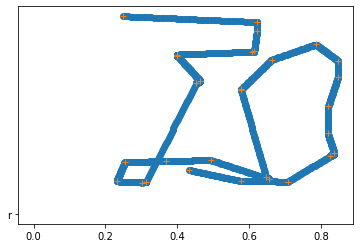

In [12]:
plt.plot(interpolate_points(X)[:, 0], interpolate_points(X)[:, 1], "o-")
plt.plot(X[:, 0], X[:, 1], "+", "r")

In [13]:
def compute_error(X):
    interpolated_points = interpolate_points(X)
    return LsqEllipse().fit(interpolated_points).compute_error(interpolated_points)
df["error"] = df.x.apply(compute_error)

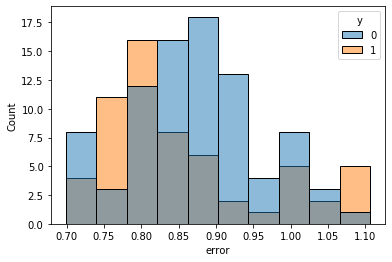

In [14]:
sns.histplot(data=df, x="error", hue="y")

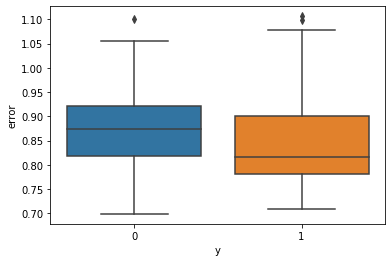

In [15]:
sns.boxplot(data=df, x="y", y="error")

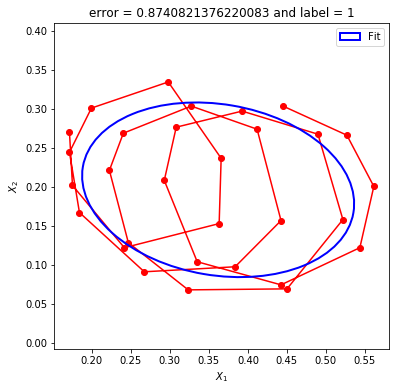

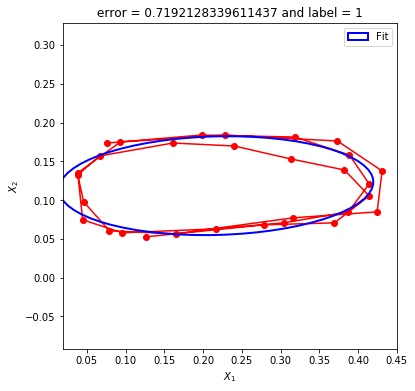

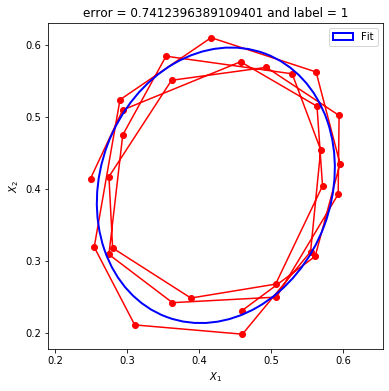

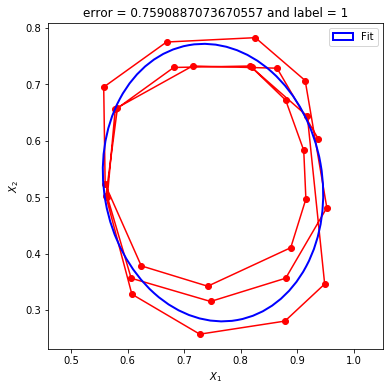

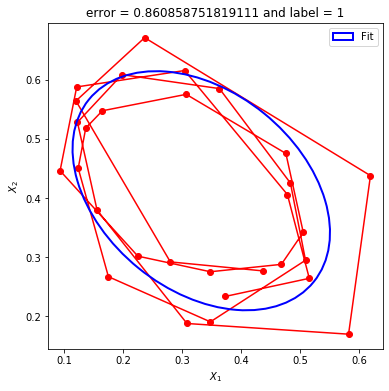

In [16]:
for i, X in enumerate(df.loc[(df.y == 1)].x.sample(5)):
    error = compute_error(X)
    reg = LsqEllipse().fit(X)
    
    center, width, height, phi = reg.as_parameters()
    fig = plt.figure(figsize=(6, 6))
    ax = plt.subplot()
    ax.axis('equal')
    ax.plot(X[:, 0], X[:, 1], '-ro', zorder=1)
    ellipse = Ellipse(
        xy=center, width=2*width, height=2*height, angle=np.rad2deg(phi),
        edgecolor='b', fc='None', lw=2, label='Fit', zorder=2
    )
    ax.add_patch(ellipse)
    
    plt.xlabel('$X_1$')
    plt.ylabel('$X_2$')
    
    plt.legend()
    plt.title(f"error = {error} and label = 1")
    plt.show()    


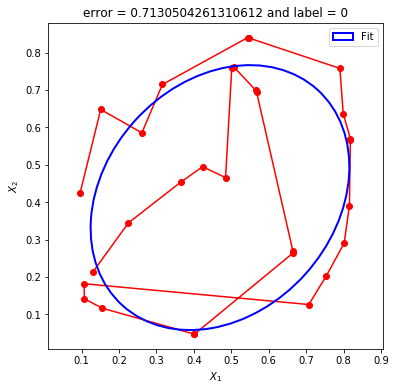

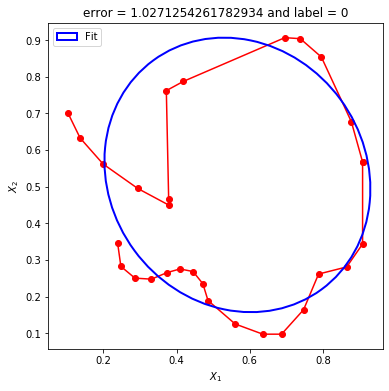

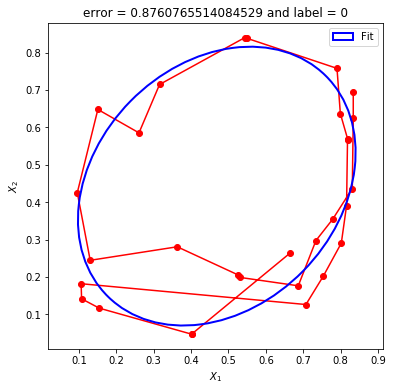

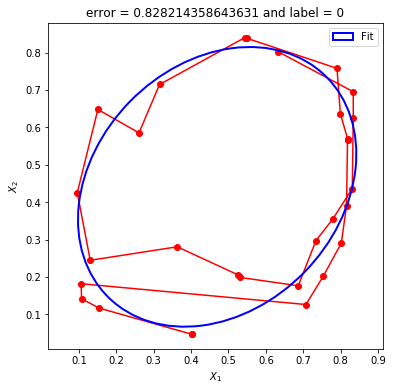

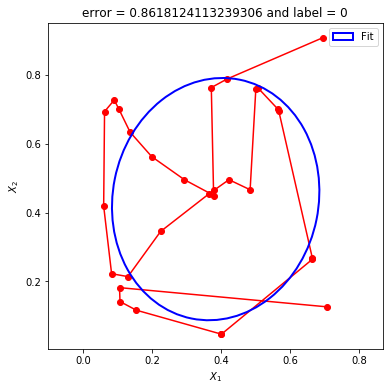

In [17]:
for i, X in enumerate(df.loc[(df.y == 0)].x.sample(5)):
    error = compute_error(X)
    reg = LsqEllipse().fit(X)
    
    center, width, height, phi = reg.as_parameters()
    fig = plt.figure(figsize=(6, 6))
    ax = plt.subplot()
    ax.axis('equal')
    ax.plot(X[:, 0], X[:, 1], '-ro', zorder=1)
    ellipse = Ellipse(
        xy=center, width=2*width, height=2*height, angle=np.rad2deg(phi),
        edgecolor='b', fc='None', lw=2, label='Fit', zorder=2
    )
    ax.add_patch(ellipse)
    
    plt.xlabel('$X_1$')
    plt.ylabel('$X_2$')
    
    plt.legend()
    plt.title(f"error = {error} and label = 0")
    plt.show()
    if i > 5:
        break